In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [5]:
#Load the data.
train = pd.read_json("input/train.json")
target_train = np.array(train['is_iceberg'])
test = pd.read_json("input/test.json")

In [6]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [7]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [8]:
train.inc_angle = train.inc_angle.replace('na', 0)
idx_tr = np.where(train.inc_angle > 0)

In [3]:
# target_train = target_train[idx_tr[0]]
# X_train = X_train[idx_tr[0],...]

In [9]:
X_angle_train = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train = np.array(train["is_iceberg"])

---


In [10]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train,
                                    X_angle_train, y_train, random_state=1, train_size=0.75)

---

In [11]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [10]:
# from keras.models import Model
# from keras.layers import Input, Dense, Reshape, concatenate, Conv2D, Flatten, MaxPooling2D
# from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D

# def simple_cnn():
#     pic_input = Input(shape=(75, 75, 3))
#     ang_input = Input(shape=(1,))

#     cnn = BatchNormalization()(pic_input)
#     for i in range(4):
#         cnn = Conv2D(8*2**i, kernel_size = (3,3), activation='relu')(cnn)
#         cnn = MaxPooling2D((2,2))(cnn)
#     cnn = GlobalMaxPooling2D()(cnn)
#     cnn = concatenate([cnn,ang_input])
#     cnn = Dense(32,activation='relu')(cnn)
#     cnn = Dense(1, activation = 'sigmoid')(cnn)

#     simple_cnn = Model(inputs=[pic_input,ang_input],outputs=cnn)

#     simple_cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return simple_cnn

In [21]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, concatenate, Conv2D, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D

def getModel():
    pic_input = Input(shape=(75, 75, 3))
    ang_input = Input(shape=(1,))
    
    cnn = BatchNormalization()(pic_input)
    cnn = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn)
    cnn = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Conv2D(128, kernel_size=(3, 3), activation='relu')(cnn)
    cnn = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Conv2D(128, kernel_size=(3, 3), activation='relu')(cnn)
    cnn = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn)
    cnn = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(cnn)
    cnn = Dropout(0.3)(cnn)
#     for i in range(4):
#         cnn = Conv2D(8*2**i, kernel_size = (3,3), activation='relu')(cnn)
#         cnn = MaxPooling2D((2,2))(cnn)
#         cnn = Dropout(0.3)(cnn)
    cnn = GlobalMaxPooling2D()(cnn)
    cnn = concatenate([cnn,ang_input])
    cnn = Dense(512,activation='relu')(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Dense(256,activation='relu')(cnn)
    cnn = Dropout(0.3)(cnn)
    
    predictions = Dense(1, activation = 'sigmoid')(cnn)

    getModel = Model(inputs=[pic_input,ang_input],outputs=predictions)

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    getModel.compile(optimizer= adam , loss = 'binary_crossentropy', metrics = ['accuracy'])
    return getModel

In [22]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=666)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(X_train, X_angle_train, y_train)

In [23]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)

In [ ]:
# Create the model
model = simple_cnn()

# Fit the model using our generator defined above
histr=model.fit_generator(gen_flow, validation_data=([X_valid, X_angle_valid], y_valid),
                    steps_per_epoch=len(X_train) / batch_size, epochs=0, callbacks=callbacks)

In [ ]:
model.summary()

In [24]:
# Create the model
model = getModel()
model.summary()
# Fit the model using our generator defined above
histr=model.fit_generator(gen_flow, validation_data=([X_valid, X_angle_valid], y_valid),
                    steps_per_epoch=24, epochs=100, callbacks=callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 75, 75, 3)    12          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 73, 73, 64)   1792        batch_normalization_3[0][0]      
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 36, 36, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
dropout_13

In [25]:
model.load_weights(filepath=file_path)

score = model.evaluate([X_train, X_angle_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
#Getting Test Score
score = model.evaluate([X_valid, X_angle_valid], y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.233633082679
Train accuracy: 0.896093100681
Test loss: 0.222421608364
Test accuracy: 0.905236908177


---

In [26]:
# Predict on test data
test_predictions = model.predict([X_test,X_angle_test])

# Create .csv
pred_df = test[['id']].copy()
pred_df['is_iceberg'] = test_predictions
pred_df.to_csv('model_01_data_DAG.csv', index = False)
pred_df.sample(3)

,id,is_iceberg
6923,5c4ef9dd,0.594054
4987,0dbd653f,0.136483
7024,248be600,0.226744


Kaggle Score: 0.2454

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


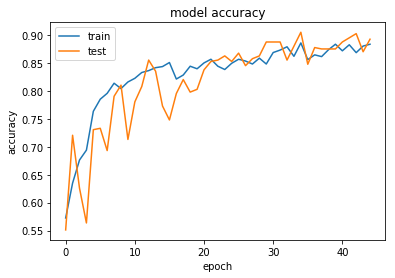

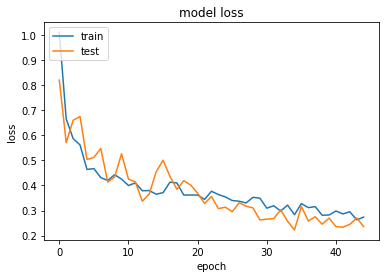

In [27]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()